<a href="https://colab.research.google.com/github/jadrzy/ProjectPythonForMachineLearning/blob/main/notebooks/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import and data divison**

In [4]:
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
MinMaxScaler,
StandardScaler,
)

!git clone https://{token}@github.com/jadrzy/PythonForMachineLearning.git

model_data = pd.read_csv("/content/PythonForMachineLearning/datasets/model_data.csv")
analize_data = pd.read_csv("/content/PythonForMachineLearning/datasets/analyze_data.csv")

analyze_data = analize_data.drop(['ID'], axis=1)
model_data = model_data.drop(['ID'], axis=1)

selected_model_data = model_data.copy()
selected_model_data = selected_model_data.loc[:, ~model_data.columns.str.startswith('Ethnicity')].drop(['Semeron', 'Country_Australia', 'Country_Canada', 'Country_New Zealand', 'Country_Other', 'Country_Republic of Ireland', 'Alcohol', 'Caffeine', 'Chocolate'], axis=1)

X1= selected_model_data.drop(['Age', 'Gender', 'Education', 'Neuroticism', 'Extraversion',
       'Openness to experience', 'Agreeableness', 'Conscientiousness',
       'Impulsiveness', 'Sensation seeking', 'Country_UK', 'Country_USA'], axis=1)

X2= selected_model_data.drop(['Cocaine', 'Crack', 'Ecstasy', 'Heroin',
       'Ketamine', 'Legal highs', 'LSD', 'Meth', 'Mushrooms', 'Nicotine',
       'Volatile substance abuse'], axis=1)

y= selected_model_data['Cannabis']

X_train, X_test, y_train, y_test= train_test_split(X2, y, test_size=0.4,random_state=1 )
X_valid, X_test, y_valid, y_test= train_test_split(X_test, y_test, test_size=0.5,random_state=1 )



fatal: destination path 'PythonForMachineLearning' already exists and is not an empty directory.


# **Classifiction for drugs**

## CV - MLPClassifier + Grid Search

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

def train_classifier(clf, parameters, scoring, X):
  X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=1)

  y_train = X_train['Cannabis'] > 3  # 0 represent range of 0-3, 1 represent range of 4-6
  X_train = X_train.drop(columns=['Cannabis'])

  grid_search = GridSearchCV(clf, parameters, cv=5, scoring=scoring) #try with different scoring: 'accuracy','f1','recall','precision'
  grid_search.fit(X_train, y_train)

  cv_res = pd.DataFrame(grid_search.cv_results_)
  cv_res['params'] = cv_res['params'].apply(lambda x: ', '.join([f'{k}={v}' for k, v in x.items()]))
  selected_columns = ['params', 'mean_test_score', 'rank_test_score']
  sorted_results = cv_res[selected_columns].sort_values(by=['rank_test_score'])
  display(sorted_results[selected_columns])

clf1 = MLPClassifier();
parameters1 =  {'solver':('sgd', 'lbfgs', 'adam'), 'hidden_layer_sizes':[(5,5), (10,5)], 'max_iter': [200, 500, 1000]}
scoring1 = 'accuracy' #try with different scoring: 'accuracy','f1','recall','precision'

clf2 = svm.SVC()
parameters2 =  {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, 1, 10]}
scoring2 = 'accuracy'

# train_classifier(clf1, parameters1, scoring1, X1)
train_classifier(clf2, parameters2, scoring2, X1)

,params,mean_test_score,rank_test_score
4,"C=1, kernel=rbf",0.808904,1
3,"C=1, kernel=linear",0.794979,2
6,"C=10, kernel=linear",0.794979,2
0,"C=0.1, kernel=linear",0.793650,4
1,"C=0.1, kernel=rbf",0.792308,5
7,"C=10, kernel=rbf",0.785672,6
5,"C=1, kernel=poly",0.775061,7
2,"C=0.1, kernel=poly",0.769079,8
8,"C=10, kernel=poly",0.759145,9


## Evaluate

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Accurancy: 0.7743724010472818
F1: 0.7275263597476954
Recall: 0.7228698412698413
Precision: 0.7339385511386978
Tp: 126
Tn: 185
Fp: 32
Fn: 34



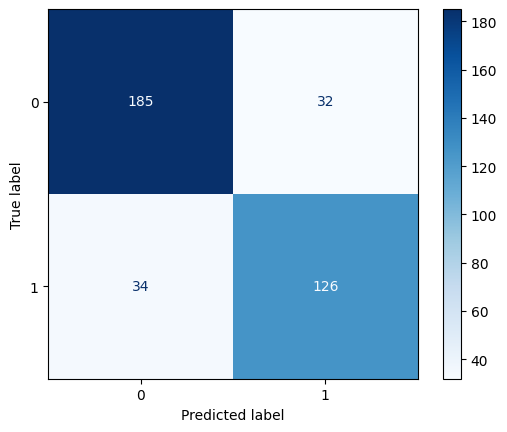

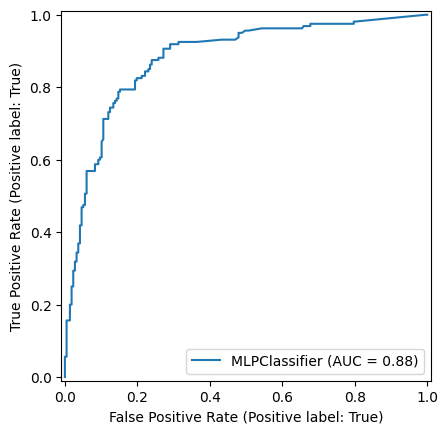

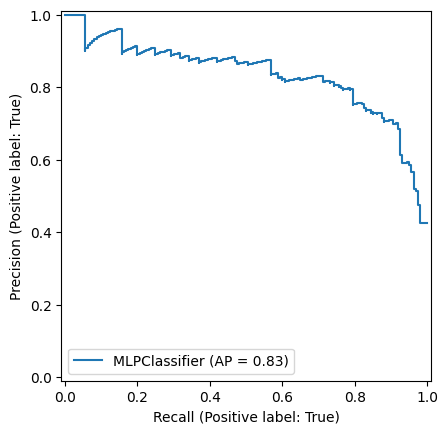

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np

def evaluate_classifier(clf, X):
  X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=1)

  y_train = X_train['Cannabis'] > 3
  X_train = X_train.drop(columns=['Cannabis'])
  y_test = X_test['Cannabis'] > 3
  X_test = X_test.drop(columns=['Cannabis'])

  clf = clf
  scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy','f1','recall','precision'])

  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print(f"Accurancy: {np.mean(scores['test_accuracy'])}")
  print(f"F1: {np.mean(scores['test_f1'])}")
  print(f"Recall: {np.mean(scores['test_recall'])}")
  print(f"Precision: {np.mean(scores['test_precision'])}")
  print(f"Tp: {tp}")
  print(f"Tn: {tn}")
  print(f"Fp: {fp}")
  print(f"Fn: {fn}")
  print("")

  cm = confusion_matrix(y_test, y_pred)
  cm_display = ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)

  RocCurveDisplay.from_estimator(clf, X_test, y_test)
  plt.show()

  PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
  plt.show()

clf1 = MLPClassifier(hidden_layer_sizes=(5, 5), max_iter=200, solver='sgd')
evaluate_classifier(clf1, X1)